#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  X = np.array(X)
  y = np.array(y)
  w = np.array(w)

  y_pred = X @ w + w0

  log_loss = np.logaddexp(0, - (y * y_pred)) # Вычисляем функцию потерь (используем np.lodaddaexp чтобы избежать переполнения при отдельном exp(- (y * y_pred)))

  loss = np.mean(log_loss) + gamma * np.sum(np.abs(w)) + beta * np.sum(w ** 2) # Функция потерь с ElasticNet регуляризацией

  return loss



#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''

    X = np.array(X)
    y = np.array(y)
    w = np.array(w)

    n = X.shape[0]

    y_pred = X @ w + w0
    exp_y = np.clip(np.exp(y * y_pred), -700, 700) # Сделаем небольшое ограничение во избежание переполнения и чрезмерно малых значений

    grad_w = -1 / n * X.T @ (y / (1 + exp_y)) + gamma * np.sign(w) + 2.0 * beta * w
    grad_w0 = -np.mean(y / (1 + exp_y))

    return (grad_w, grad_w0)


In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.


In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42, batch_size = 1):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.batch_size = batch_size # Размер батча (изначально 1 для sgd)
        self.loss_history = [] # Добавим историю лоссов


    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, m_features = X.shape


        y_sign = np.where(y <= 0, -1, 1) # Переделываем входные данный под формат классов (-1, 1)

        gen = np.random.default_rng(self.random_state) # Генератор для псевдослучайных значений
        # Начальные веса
        self.w = gen.normal(loc=0.0, scale=0.01, size=m_features)
        self.w0 = 0.0

        for i in range(self.max_iter):
            # Берём батч (если его размер больше данных, берём все данные)
            ids = gen.choice(n_samples, min(self.batch_size, n_samples), replace=False)
            X_batch = X[ids]
            y_batch = y_sign[ids]

            grad_w, grad_w0 = get_grad(X_batch, y_batch, self.w, self.w0, self.gamma, self.beta)



            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            self.loss_history.append(loss(X, y_sign, self.w, self.w0, self.gamma, self.beta))

            weight_change = np.linalg.norm(self.lr * grad_w) + abs(self.lr * grad_w0) # Изменение модели за итерацию для критерия остановки
            if weight_change < self.tolerance:
                break

        # Обозначим атрибуты для совместимости с sklearn
        self.classes_ = np.array([-1, 1])
        self.coef_ = self.w.reshape(1, -1)
        self.intercept_ = np.array([self.w0])

        return self


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        y_pred = (self.predict_proba(X)[:, 1] >= 0.5).astype(int) # Значения по вероятности
        return 2 * y_pred - 1 # Переводим в формат (-1, 1)


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        X = np.asarray(X)

        pred = np.clip(X @ self.w + self.w0, -700, 700)

        proba_class1 = 1 / (1 + np.exp(-pred)) # Веросятность класса 1
        proba_class0 = 1.0 - proba_class1 # Класса 0 (-1)
        return np.column_stack([proba_class0, proba_class1])


In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)
print(y)

[1 1 0 ... 0 0 0]


####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    w = model.coef_[0]
    w0 = model.intercept_[0]

    # Границы отображения
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Сетка точек
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    # Считаем значения для каждой точки
    pred = w[0] * xx + w[1] * yy + w0

    plt.figure(figsize=(10, 8))

    # Заливка областей с разделителем в виде pred=0
    plt.contourf(xx, yy, pred, levels=[-np.inf, 0, np.inf], alpha=0.2, colors=['black', 'white'])

    # Отображение точек
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='black', label='Class 0', alpha=0.8)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='white', label='Class 1', alpha=0.8)

    # Линия разделения
    plt.contour(xx, yy, pred, levels=[0], colors='red', linewidths=1)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


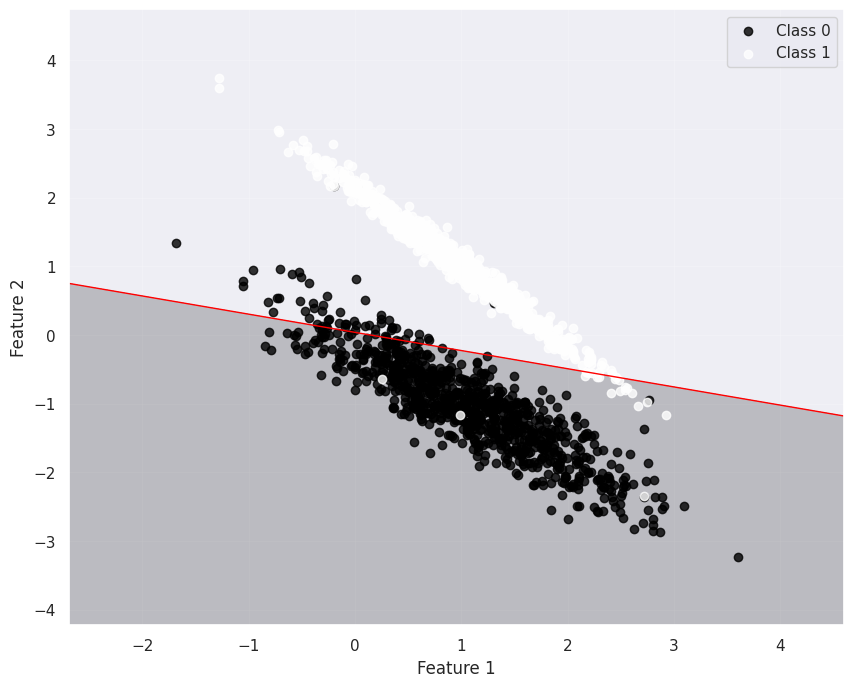

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    if hasattr(model, 'loss_history_') or len(model.loss_history) > 0: # Если существует атрибут в модели и есть хотя бы 1 элемент

        plt.figure(figsize=(10, 6))
        iterations = range(0, len(model.loss_history))
        plt.plot(iterations, model.loss_history, marker='o', markersize=1, linewidth=1)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(alpha=0.3)
        plt.show()

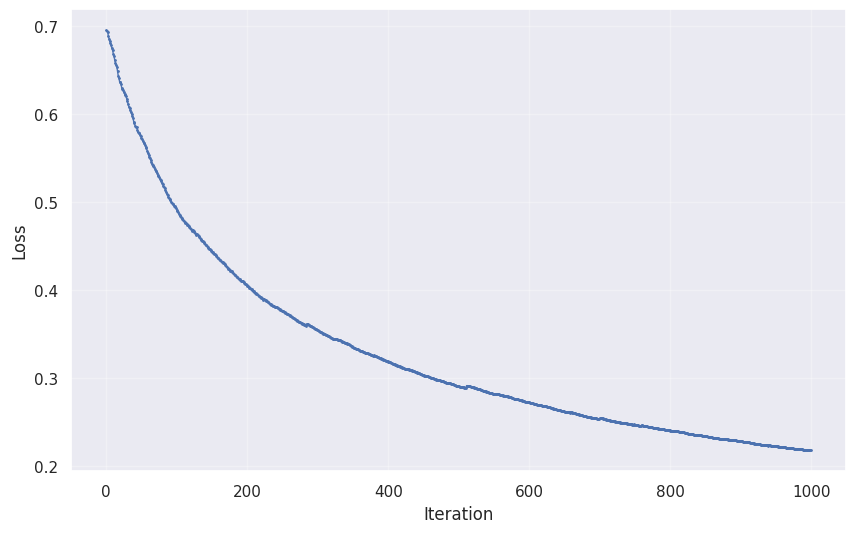

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Обучающая и тестовая выборки в соотношении 0.8:0.2 (random_state решил оставиит 42 (в целом, для всего файла), изначально он таким был в частях кода для проверки, решил не менять)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

kernels = ['linear', 'rbf', 'sigmoid']
с_values = [0.1, 1, 10, 100]

for kernel in kernels:
    for с in с_values:
        model = SVC(kernel=kernel, C=с, random_state=42, probability=True)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f'Kernel: {kernel}',
            f'C: {с}',
            f'Accuracy: {acc}',
            f'Precision: {prec}',
            f'Recall: {rec}',
            f'F1-Score: {f1}',
            f'AUC-ROC: {auc}')




Kernel: linear C: 0.1 Accuracy: 0.9916666666666667 Precision: 0.988950276243094 Recall: 0.9944444444444445 F1-Score: 0.9916897506925207 AUC-ROC: 0.9937962962962963
Kernel: linear C: 1 Accuracy: 0.9916666666666667 Precision: 0.988950276243094 Recall: 0.9944444444444445 F1-Score: 0.9916897506925207 AUC-ROC: 0.994104938271605
Kernel: linear C: 10 Accuracy: 0.9916666666666667 Precision: 0.988950276243094 Recall: 0.9944444444444445 F1-Score: 0.9916897506925207 AUC-ROC: 0.9943827160493828
Kernel: linear C: 100 Accuracy: 0.9916666666666667 Precision: 0.988950276243094 Recall: 0.9944444444444445 F1-Score: 0.9916897506925207 AUC-ROC: 0.9943827160493828
Kernel: rbf C: 0.1 Accuracy: 0.9944444444444445 Precision: 0.9944444444444445 Recall: 0.9944444444444445 F1-Score: 0.9944444444444445 AUC-ROC: 0.9969444444444444
Kernel: rbf C: 1 Accuracy: 0.9944444444444445 Precision: 0.9944444444444445 Recall: 0.9944444444444445 F1-Score: 0.9944444444444445 AUC-ROC: 0.9972839506172839
Kernel: rbf C: 10 Accuracy

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [13]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42, batch_size=1):
        self.C = C
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.batch_size = batch_size #Размер батча (изначально 1 для sgd)
        self.loss_history = []

    def _hinge_loss(self, X, y, w, w0): # Вычисление функции потерь с регуляризацией l2
        loss = np.maximum(0, 1 - y * (X @ w + w0))
        reg = (1 / (2 * self.C)) * np.sum(w ** 2)
        return np.mean(loss) + reg

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, m_features = X.shape

        y_sign = np.where(y <= 0, -1, 1) # Так же приводим к (-1, 1)

        # Генератор псевдослучайных чисел
        gen = np.random.default_rng(self.random_state)
        # Начальные коэффициенты
        self.w = gen.normal(0, 0.01, size=m_features)
        self.w0 = 0.0

        beta = 1.0 / (2 * self.C)

        for _ in range(self.max_iter):
            ids = gen.choice(n_samples, min(self.batch_size, n_samples), replace=False)
            X_batch, y_batch = X[ids], y_sign[ids]

            pred = X_batch @ self.w + self.w0

            # Маска объектов которые неправильно классифицированы или лежат в зазоре (будем обрабатывать их, штрафовать)
            bad_pred_mask = y_batch * pred < 1

            grad_w = np.zeros_like(self.w)
            if np.any(bad_pred_mask):
                grad_w = -np.mean(y_batch[bad_pred_mask][:, None] * X_batch[bad_pred_mask], axis=0)
            grad_w += 2 * beta * self.w

            grad_w0 = 0.0
            if np.any(bad_pred_mask):
                grad_w0 = -np.mean(y_batch[bad_pred_mask])

            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            self.loss_history.append(self._hinge_loss(X, y_sign, self.w, self.w0))

            weight_change = np.linalg.norm(self.lr * grad_w) + abs(self.lr * grad_w0)
            if weight_change < self.tolerance:
                break

        # Для совместимости с sklearn
        self.classes_ = np.array([-1, 1])
        self.coef_ = self.w.reshape(1, -1)
        self.intercept_ = np.array([self.w0])

        return self

    def predict(self, X):
        X = np.asarray(X)
        y_pred = (X @ self.w + self.w0 >= 0).astype(int)
        return 2 * y_pred - 1 # Для возврата (-1, 1)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''

        # Вычисляем вероятность (условно)
        X = np.asarray(X)

        pred = np.clip(X @ self.w + self.w0, -700, 700)

        proba_class1 = 1 / (1 + np.exp(-pred))
        proba_class0 = 1.0 - proba_class1
        return np.column_stack([proba_class0, proba_class1])




In [14]:
c_values = [0.1, 1, 10, 100]
for c in с_values:
        model = HingeLossClassifier(C=c, lr=0.1, max_iter=2000, batch_size=1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        print(f'C: {c}',
            f'Accuracy: {acc}',
            f'Precision: {prec}',
            f'Recall: {rec}',
            f'F1-Score: {f1}',
            f'AUC-ROC: {auc}')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C: 0.1 Accuracy: 0.5 Precision: 0.0 Recall: 0.0 F1-Score: 0.0 AUC-ROC: 0.5
C: 1 Accuracy: 0.8666666666666667 Precision: 0.8 Recall: 0.9777777777777777 F1-Score: 0.88 AUC-ROC: 0.9731481481481482
C: 10 Accuracy: 0.9861111111111112 Precision: 0.9943502824858758 Recall: 0.9777777777777777 F1-Score: 0.9859943977591037 AUC-ROC: 0.9897222222222223
C: 100 Accuracy: 0.9916666666666667 Precision: 0.988950276243094 Recall: 0.9944444444444445 F1-Score: 0.9916897506925207 AUC-ROC: 0.9938271604938271


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [15]:
from collections import Counter

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        self.classes = np.unique(self.y_train) # Смотрим какие классы вообще есть
        return self

    def _calc_dist(self, x, X): # Считаем расстояния (сделаем обработку метрик, чтобы можно быо дополнить при надобности)
        dists = None
        if self.metric == "euclidean":
          dists = np.sum((X - x) ** 2, axis=1)
        return dists

    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)] # Берём класс с самой большой вероятностью

    def predict_proba(self, X): # Считаем вероятности классов (для каждого объекта есть вектор, где каждое значение соответствует вероятности для i-ого класса)
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes)

        proba = np.zeros((n_samples, n_classes))

        for i, x in enumerate(X):
            dists = self._calc_dist(x, self.X_train)

            k_ids = np.argsort(dists)[:self.n_neighbors]

            kn_classes = self.y_train[k_ids]

            counts = Counter(kn_classes) # Счётчик значений (похож на словарь)
            for j, cls in enumerate(self.classes):
                proba[i, j] = counts.get(cls, 0) / self.n_neighbors

        return proba


In [16]:
knn = KNNClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("AUC-ROC  :", roc_auc_score(y_test, y_proba))

Accuracy : 0.9916666666666667
Precision: 0.988950276243094
Recall   : 0.9944444444444445
F1-Score : 0.9916897506925207
AUC-ROC  : 0.9943518518518519


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:

df = pd.read_csv('fashion-mnist.csv') # Я скачал файлы с обучающей и тестовой выборкой и объединил в один))

train_df = df.iloc[:50000]
test_df = df.iloc[50000:]

X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values

X_test = test_df.drop(columns=['label']).values
y_test = test_df['label'].values


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

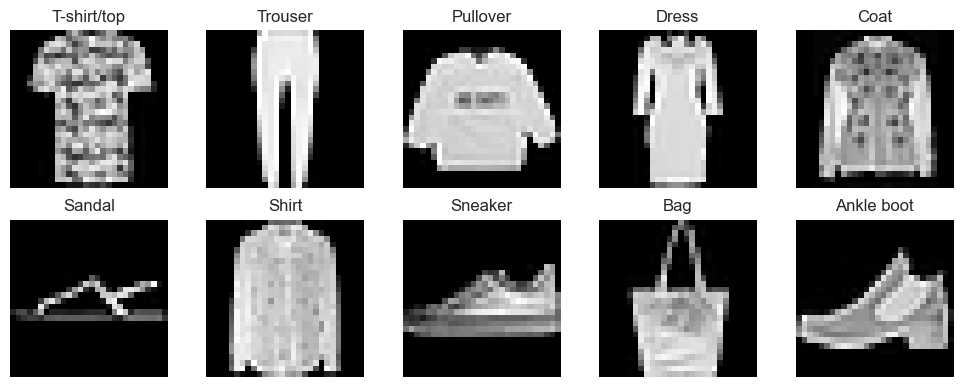

In [ ]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for cls in range(10):
    ids = np.where(y_train == cls)[0][0]
    image = X_train[ids].reshape(28, 28)

    axes[cls].imshow(image, cmap='gray')
    axes[cls].set_title(class_names[cls])
    axes[cls].axis('off')

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.utils import resample

# Сделаем всё для обеих нормировок
X_train_std_small, y_train_std_small = resample(
    X_train_std, y_train,
    n_samples=5000, # Возьмём тольько часть выборки для подбора параметров для логистической регрессии (иначе очень долго)
    random_state=42,
    stratify=y_train # Сохраняем пропорции классов
)

X_train_minmax_small, y_train_minmax_small = resample(
    X_train_minmax, y_train,
    n_samples=5000, # Аналогично, часть выборки
    random_state=42,
    stratify=y_train
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg_params = [ # Перебёрем типы регуляризации, так как происхождение данных может влиять на оптимальную,
    # коэффициент регуляризации соответственно (очевидно), а для ElasticNet также баланс между l1 и l2
    # Другие параметры были выбраны с учётом ускорить (но не перегибать), так моделей получается много + 5 фолдов на каждую
     {
        'penalty': ['l1'],
        'C': [0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [600],
        'tol': [5e-3]
    },
    {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [600],
        'tol': [5e-3]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0.35, 0.5, 0.65],
        'max_iter': [600],
        'tol': [5e-3]
    }
]

# Перебор для обеих нормировок
log_reg = LogisticRegression(random_state=42)
grid_log_reg_std = GridSearchCV(
    log_reg,
    log_reg_params,
    cv=5,
    scoring='accuracy',
    verbose=3 # Вывод состояний
)

grid_log_reg_minmax = GridSearchCV(
    log_reg,
    log_reg_params,
    cv=5,
    scoring='accuracy',
    verbose=3
)

grid_log_reg_std.fit(X_train_std_small, y_train_std_small)

print("Best params:", grid_log_reg_std.best_params_)
print("Best accuracy:", grid_log_reg_std.best_score_)

grid_log_reg_minmax.fit(X_train_minmax_small, y_train_minmax_small)

print("Best params:", grid_log_reg_minmax.best_params_)
print("Best accuracy:", grid_log_reg_minmax.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=0.1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.827 total time=  36.4s
[CV 2/5] END C=0.1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.818 total time=  24.8s
[CV 3/5] END C=0.1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.810 total time=  33.6s
[CV 4/5] END C=0.1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.795 total time=  33.7s
[CV 5/5] END C=0.1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.817 total time=  38.1s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.832 total time=  29.2s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.826 total time=  37.1s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.822 total time=  27.6s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=saga, tol=0.005;, score=0.803 total time=  27.3s
[CV 5/5] END C=1, max_iter=60

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Тут переберём количество соседей,чтобы найти оптимальное количество для определения класса (при малом коичестве страдает качество, большое может быть избыточно),
# также переберём метод определения класса (с учётом расстояния до выбранных соседей или при равенстве, узнать какой метод в данном случае лучше)
# и конечно метрику расстояний (оказывает разное влияние на поиск соседей (например по разному воспринимает выбросы))

# Подберём в этот раз на уменьшенной выборке
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto']
}

knn = KNeighborsClassifier()

grid_knn_std = GridSearchCV(
    knn,
    knn_params,
    cv=5,
    scoring='accuracy',
    verbose=3
)

grid_knn_minmax = GridSearchCV(
    knn,
    knn_params,
    cv=5,
    scoring='accuracy',
    verbose=3
)


grid_knn_std.fit(X_train_std_small, y_train_std_small)

print("Best params:", grid_knn_std.best_params_)
print("Best accuracy:", grid_knn_std.best_score_)

grid_knn_minmax.fit(X_train_minmax_small, y_train_minmax_small)

print("Best params:", grid_knn_minmax.best_params_)
print("Best accuracy:", grid_knn_minmax.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.811 total time=   1.9s
[CV 2/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.816 total time=   0.0s
[CV 3/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.804 total time=   0.0s
[CV 4/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.795 total time=   0.0s
[CV 5/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.822 total time=   0.0s
[CV 1/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.818 total time=   0.0s
[CV 2/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.821 total time=   0.0s
[CV 3/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.815 total time=   0.0s
[CV 4/5] END algorithm=auto, metric=euclidean, n

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Попробуем на всей выборке

knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto']
}

knn = KNeighborsClassifier()

grid_knn_std = GridSearchCV(
    knn,
    knn_params,
    cv=5,
    scoring='accuracy',
    verbose=3
)

grid_knn_minmax = GridSearchCV(
    knn,
    knn_params,
    cv=5,
    scoring='accuracy',
    verbose=3
)


grid_knn_std.fit(X_train_std, y_train)

print("Best params:", grid_knn_std.best_params_)
print("Best accuracy:", grid_knn_std.best_score_)

grid_knn_minmax.fit(X_train_minmax, y_train)

print("Best params:", grid_knn_minmax.best_params_)
print("Best accuracy:", grid_knn_minmax.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.854 total time=   5.7s
[CV 2/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.848 total time=   5.6s
[CV 3/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.851 total time=   5.6s
[CV 4/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.853 total time=   5.5s
[CV 5/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform;, score=0.847 total time=   5.5s
[CV 1/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.855 total time=   5.4s
[CV 2/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.849 total time=   5.4s
[CV 3/5] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance;, score=0.853 total time=   5.7s
[CV 4/5] END algorithm=auto, metric=euclidean, n

In [ ]:
from sklearn.linear_model import LogisticRegression

# Сделал новые модели регрессии, так как перезапускал kernel в vscode и надо было бы заново запускать подбор параметров, а это 1ч, также чуть уменьшил параметр tol: 0.005 -> 0.003 (качество по идее должно только улучшиться)
best_log_reg_std = LogisticRegression(C=0.1, max_iter=600, penalty='l2', solver='lbfgs', tol=0.003)
best_log_reg_minmax = LogisticRegression(C=1, l1_ratio=0.35, max_iter=600, penalty='elasticnet', solver='saga', tol=0.003)
best_knn_std = grid_knn_std.best_estimator_
best_knn_minmax = grid_knn_minmax.best_estimator_

# Обучим уже на полной выборке
best_log_reg_std.fit(X_train_std, y_train)
best_log_reg_minmax.fit(X_train_minmax, y_train)

log_reg_std_score = best_log_reg_std.score(X_test_std, y_test)
log_reg_minmax_score = best_log_reg_minmax.score(X_test_minmax, y_test)
knn_std_score = best_knn_std.score(X_test_std, y_test)
knn_minmax_score = best_knn_minmax.score(X_test_minmax, y_test)

print('LogisticRegression + StandardScaler: ', log_reg_std_score)
print('LogisticRegression + MinMaxScaler: ', log_reg_minmax_score)
print('KNeighborsClassifier + StandardScaler: ', knn_std_score)
print('KNeighborsClassifier + MinMaxScaler: ', knn_minmax_score)


LogisticRegression + StandardScaler:  0.8537
LogisticRegression + MinMaxScaler:  0.8544
KNeighborsClassifier + StandardScaler:  0.8652
KNeighborsClassifier + MinMaxScaler:  0.86395


KNN отработал лучше и прогресс с 5000 до 50000 объектов обучения лучше у него. Вероятно, KNN может лучше справляется при разделении например схожих объектов (футболка и рубашка), может учитывать более локальные различия, когда логистическая регрессия пытается найти более глобальные линейные разделители (правда стоит учесть, что на результат регрессии могут также влиять и параметры модели, и при увеличении числа итераций и уменьшения критерия остановки результат может стать лучше).

При этом для KNN чуть лучше StandardScaler, так как менее подвержен выбросам, помогает лучше учитывать информативность признаков (пикселей), то есть каждый признак-пиксель вносит свой определённый вклад (пиксель, который сильнее влияет и меняется от класса к классу, будет сильнее влиять на расстояние).

Но для логистической регресии чуть лучше MinMaxScaler, так в отличие от knn она сама подбирает веса признаков (+ меньше проблем со справедливой регуляризацей).

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Модель не сможет отличить классы и будет предсказывать равную вероятность для обоих, так как все объекты имеют одинаковые признаки (и равное количество объектов для -1 и 1). При этом линейное предсказание будет стремится к 0 (w * x + b), что вытекает также из минимизации функции потерь (если расписать) и симметричности градиента для классов -1 и 1 (ещё и объектов равное количество (то есть в среднем будет браться равное количество объектов одного класса и другого)). Таким образом, модель будет по сути угадывать (точность 0.5), а значение функции потерь будет ln(2).